In [1]:
import numpy as np
import pyci
import psi4

In [2]:
# Lets intiate AOint() a subclass of psi4utils() 
aoint = pyci.utils.AOint('aug-cc-pvqz', '../.xyz/He.xyz')
# saves all the necessary integrals as .npz files
aoint.save_all_aoints()
aoint.save_ao_dpints()
aoint.save_ao_qdints()
# run scf and get info for canonical HF orbitals
aoint.save_mo_info()
# lets load  ao_erints, mo_info and try to get the CIS matrix
ao_erints = np.load('ao_erints.npz')['electron_repulsion_aoints'] 
eps_a = np.load('mo_scf_info.npz')['eps_a']
Ca = np.load('mo_scf_info.npz')['Ca'] 
ao_dipoles = np.load('ao_dpints.npz')
ao_quadrupoles = np.load('ao_qdints.npz')
# lets convert our erints from AO basis to MO basis
mo_erints = aoint.eri_ao2mo(Ca, ao_erints)
mo_dpx = aoint.matrix_ao2mo(Ca, ao_dipoles['dpx_aoints'])
mo_dpy = aoint.matrix_ao2mo(Ca, ao_dipoles['dpy_aoints'])
mo_dpz = aoint.matrix_ao2mo(Ca, ao_dipoles['dpz_aoints'])
mo_qdxx = aoint.matrix_ao2mo(Ca, ao_quadrupoles['qdxx_aoints'])
mo_qdyy = aoint.matrix_ao2mo(Ca, ao_quadrupoles['qdyy_aoints'])
mo_qdzz = aoint.matrix_ao2mo(Ca, ao_quadrupoles['qdzz_aoints'])
del ao_erints, ao_dipoles, ao_quadrupoles

Size of the ERI tensor will be 0.04 Gb

Ground state SCF Energy : -2.86152200 

Nuclear repulsion energy : 0.00000000 

Total electronic energy : -2.86152200 



In [3]:
nbf, nmo, nso, na, nb, nocc, nvirt = aoint.get_orb_info(aoint.wfn)

 ORBITAL INFORMATION  
-----------------------
Basis functions   : 46  
Molecular orbitals: 46  
Spin Orbitals     : 92  
Alpha Orbitals    : 1  
Beta Orbitals     : 1  
Occupied Orbitals : 1  
Virtual Orbitals  : 45  



In [4]:
scf_energy = aoint.scf_energy
psi4_cisd = psi4.energy('CISD')

In [5]:
orbinfo = (nocc, nmo)
active_space = (nocc,nvirt)
options = { 'singles' : True,
            'full_cis' : True,
            'doubles' : True,
            'doubles_iiaa' : True,
            'doubles_iiab' : True,
            'doubles_ijaa' : True,
            'doubles_ijab_A' : True,
            'doubles_ijab_B' : True}
csfs, num_csfs = pyci.configint.rcisd.generate_csfs(orbinfo, active_space, options)
num_csfs, sum(num_csfs)

([1, 45, 45, 990, 0, 0, 0], 1081)

In [6]:
HCISD = pyci.configint.rcisd.comp_hcisd(eps_a, mo_erints, scf_energy, orbinfo, active_space, options, ncore=2)

In [7]:
HCISD0 = HCISD - scf_energy*np.eye(sum(num_csfs))
vals, vecs = np.linalg.eigh(HCISD0)
vals_scaled = vals + scf_energy

In [9]:
vals_scaled[0], psi4_cisd, abs(vals_scaled[0] - psi4_cisd)

(-2.9025335994179526, -2.9025335994179478, 4.884981308350689e-15)

In [10]:
csf_dpx  = pyci.configint.rcisd.comp_oeprop_matrix(mo_dpx, orbinfo, active_space, options)
csf_dpy  = pyci.configint.rcisd.comp_oeprop_matrix(mo_dpy, orbinfo, active_space, options)
csf_dpz  = pyci.configint.rcisd.comp_oeprop_matrix(mo_dpz, orbinfo, active_space, options)

In [11]:
from pyci.integrators import RK4
from pyci.utils import excite

In [20]:
fs_to_au = 41.341374575751
ti = 0.0 
tf = 20.0*fs_to_au
dt = 0.0001*fs_to_au 
sigma = 5.1*fs_to_au
E0 = 0.07549
w0 = 0.056
phase = 0.0
params = E0, w0, ti, 2*sigma, sigma, phase
func = lambda t :  -1j * (HCISD0 - excite.sin2_pulse(t, params)*csf_dpz)
psi0 = vecs[0]
propagator = RK4(func, psi0, ti, tf, dt)

<function <lambda> at 0x7f399f3dea70>


In [21]:
psi, time = propagator._time_propagation()

In [17]:
dpz_moments = [abs(np.einsum('i,ij,j', np.conjugate(yi), csf_dpz, yi, optimize=True)) for yi in psi]

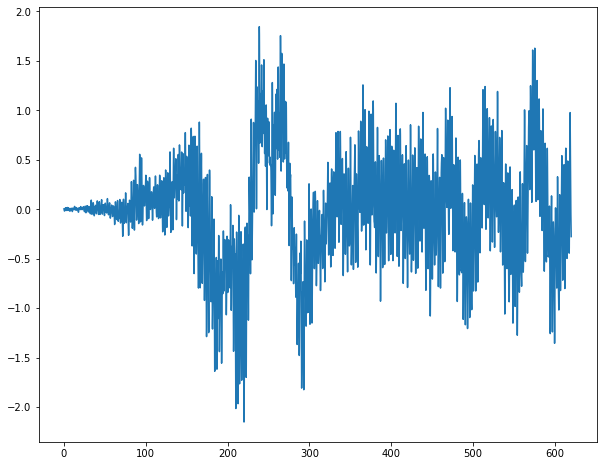

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8), facecolor='white')
plt.plot(time, dpz_moments)